In [16]:
# from get_models import Progress_Bar, Encoder, Decoder, CovarianceMatrix, thermometer_encode_df

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from torchmin import minimize
import scipy.stats as stats
from scipy.stats import chi2, chisquare

In [17]:
# Parameter setzen
n_participants = 500
years = 10
effect_of_sex = 0.0
effect_of_age = -0.1

# random effects
var_intercept = 2
var_slope = 0.1

noise_var = 0.1

# fixed effects
weights = {'Systolic_BP': -0.1, 'Diastolic_BP': -0.1, 'Cholesterol': -0.2, 'Triglycerides': -0.2, 'BMI': -0.4, 'Creatinin': -0.1}


def simulate_data(num_participants):
    data = []
    # simulate data for each patient 
    for participant_id in range(1, n_participants + 1):
        age = np.random.randint(30, 61)  # patients are between 30 and 60
        gender = np.random.choice([0, 1])
        group = np.random.choice([0, 1])
        baseline_bp_sys = np.random.normal(120, 10)  # normal distributed systolic blood pressure vals
        baseline_bp_dia = np.random.normal(80, 10)  # normal ditributed diastolic blood pressure vals
        baseline_cholesterol = np.random.normal(200, 30)  # Cholesterin in mg/dL
        baseline_triglycerides = np.random.normal(150, 20)  # Triglyceride in mg/dL
        baseline_creatinin = np.random.normal(1,0.2) #creatinin in mg/dL
        baseline_bmi = np.random.normal(25, 4)  # BMI
        years_after_treatment = 0

        # randomly determine when the patient gets treatment 
        get_treatment = np.zeros((years), dtype=int)
        # start_points = np.random.randint(3, years)
        # for _ in range(years):
        #     get_treatment[start_points:] = 1

        # simulate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, np.sqrt(var_slope))
        noise = np.random.normal(0.0, np.sqrt(noise_var))
        
        # simulate data for each year
        for year in range(years):
            # effect of the treatment
            if get_treatment[year] == 1:
                delta_bp = -2 * year  # treatment issues improvement of data  
                delta_cholesterol = -5 * year  # Cholesterin reduction of treatment
                delta_triglycerides = -3 * year  # Triglyceride reduction of treatment
                delta_creatinin = -0.08 * year
                years_after_treatment += 1
            else:
                delta_bp = -0.5 * year  # minimal natural improvement
                delta_cholesterol = -1 * year
                delta_triglycerides = -1 * year
                delta_creatinin = -0.01 * year

            # calculate the scores for each year
            sys_bp = baseline_bp_sys + delta_bp + np.random.normal(0, 5)
            dia_bp = baseline_bp_dia + delta_bp + np.random.normal(0, 5)
            cholesterol = baseline_cholesterol + delta_cholesterol + np.random.normal(0, 10)
            triglycerides = baseline_triglycerides + delta_triglycerides + np.random.normal(0, 5)
            creatinin = baseline_creatinin + delta_creatinin + np.random.normal(0, 0.1)
            # cholesterol = max(100, baseline_cholesterol + delta_cholesterol + np.random.normal(0, 10))
            # triglycerides = max(50, baseline_triglycerides + delta_triglycerides + np.random.normal(0, 5))
            # creatinin = max(0.6, baseline_creatinin + delta_creatinin + np.random.normal(0, 0.1))

            bmi = baseline_bmi + np.random.normal(0, 0.5)  
            
            # calculate the test score 
            health_score = (150 + random_intercept +
                        weights['Systolic_BP'] * sys_bp +
                        weights['Diastolic_BP'] * dia_bp +
                        weights['Cholesterol'] * cholesterol +
                        weights['Triglycerides'] * triglycerides +
                        weights['BMI'] * bmi + 
                        weights['Creatinin'] * creatinin +
                        effect_of_sex * gender + 
                        effect_of_age * age +
                        random_slope +
                        noise)
            
            yearly_data = {
                'patient_id': participant_id,
                'Year': year,
                'Age': age,
                'Group': group,
                'Gender': gender,
                'Get_treatment': get_treatment[year] ,
                'Years_after_treatment' : years_after_treatment,
                'Systolic_BP': sys_bp,
                'Diastolic_BP': dia_bp,
                'Cholesterol': cholesterol,
                'Creatinin' : creatinin, 
                'Triglycerides': triglycerides,
                'BMI': bmi,
                'Health_Score': health_score,
                'random_slope': random_slope,
                'random_intercept': random_intercept
            }
            
            data.append(yearly_data)
            age += 1
    return pd.DataFrame(data)

# Erstelle einen DataFrame aus den gesammelten Daten
df = pd.DataFrame(simulate_data(n_participants))
data = simulate_data(n_participants)

In [18]:
df

,patient_id,Year,Age,Group,Gender,Get_treatment,Years_after_treatment,Systolic_BP,Diastolic_BP,Cholesterol,Creatinin,Triglycerides,BMI,Health_Score,random_slope,random_intercept
0,1,0,37,1,0,0,0,109.086950,87.108576,160.418774,1.245918,161.834389,28.053392,49.325953,0.078607,-1.590284
1,1,1,38,1,0,0,0,103.219926,99.855687,156.228090,1.169707,167.170729,29.951217,47.557304,0.078607,-1.590284
2,1,2,39,1,0,0,0,107.486116,88.482177,165.625858,1.350113,161.112294,27.945825,48.284285,0.078607,-1.590284
3,1,3,40,1,0,0,0,108.073403,93.170821,161.929460,1.191888,159.788423,28.018015,48.647693,0.078607,-1.590284
4,1,4,41,1,0,0,0,111.711796,93.147610,171.573847,1.177238,151.694209,28.335754,47.750509,0.078607,-1.590284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,500,5,38,1,1,0,0,132.848666,100.448042,207.481018,0.433354,149.252805,28.200764,42.725784,-0.112226,1.731582
4996,500,6,39,1,1,0,0,132.824891,92.091778,208.703309,0.503187,131.204101,27.712311,47.017469,-0.112226,1.731582
4997,500,7,40,1,1,0,0,136.063550,97.570896,181.597850,0.542979,138.690165,28.430908,49.678152,-0.112226,1.731582
4998,500,8,41,1,1,0,0,135.701899,87.901812,203.372168,0.498984,134.483574,28.658587,46.981008,-0.112226,1.731582


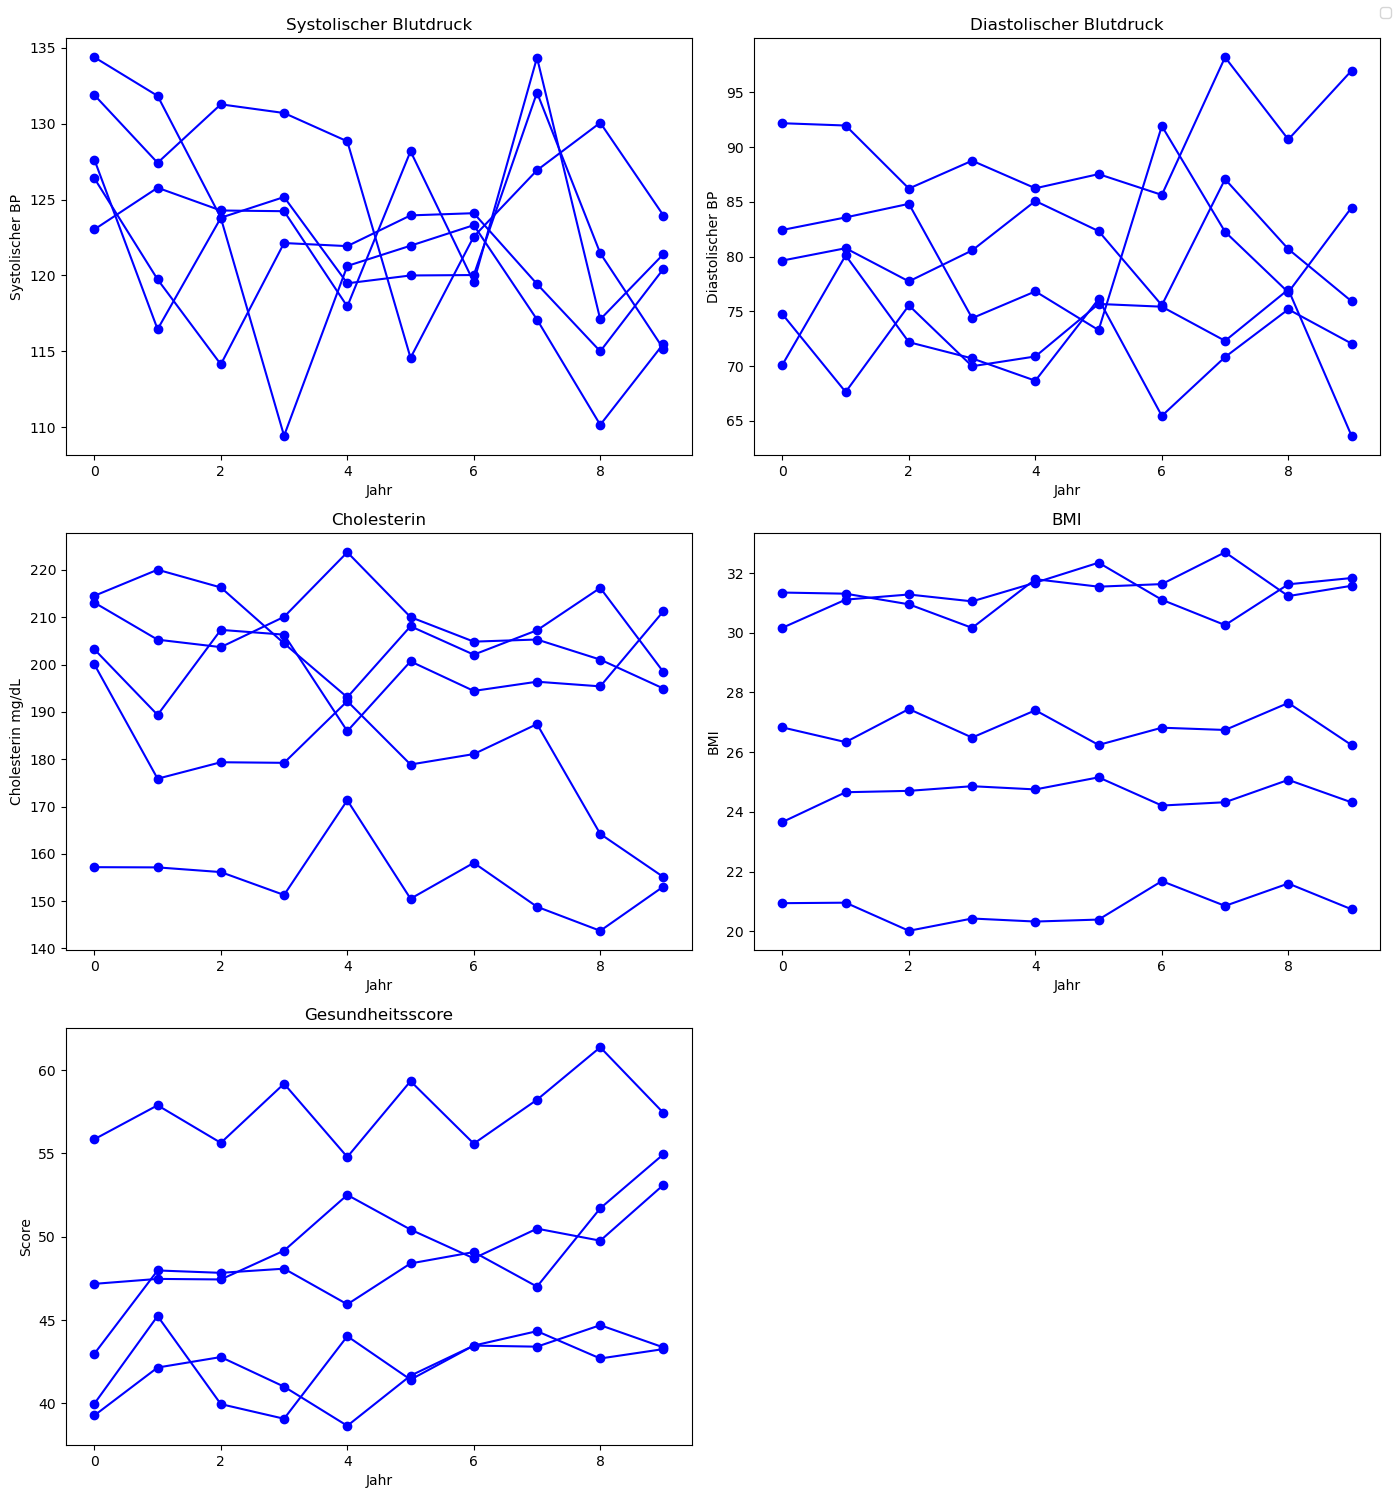

In [19]:
# choose 20 random patients
random_participants = np.random.choice(df['patient_id'].unique(), 5, replace=False)

# create plots for the chosen patients
fig, ax = plt.subplots(3, 2, figsize=(14, 15))  # 3x2 plot

# Farben für die Gruppen definieren
colors = {'Intervention': 'blue', 'Control': 'red'}

# Boolean flags to add legend only once
legend_added = {
    'Pre-Treatment': False,
    'Post-Treatment': False,
    'Treatment-without-effect': False
}

# Plotte für jede Metrik und füge nur einmal die Legende für jede Gruppe hinzu
for participant in random_participants:
    subset = df[df['patient_id'] == participant]
    treatment_switch = subset[subset['Get_treatment'].diff() == 1].index
    group = subset['Group'].iloc[0]

    if not treatment_switch.empty:
        switch_point = treatment_switch[0] -1
        if not legend_added['Pre-Treatment']:
            ax[0, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Systolic_BP'], marker='o', color="red", label='Pre-Treatment')
            legend_added['Pre-Treatment'] = True
        else:
            ax[0, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Systolic_BP'], marker='o', color="red")

        if not legend_added['Post-Treatment']:
            ax[0, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Systolic_BP'], marker='o', color="green", label='Post-Treatment')
            legend_added['Post-Treatment'] = True
        else:
            ax[0, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Systolic_BP'], marker='o', color="green")

        ax[0, 1].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Diastolic_BP'], marker='o', color="red")
        ax[0, 1].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Diastolic_BP'], marker='o', color="green")
        ax[1, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Cholesterol'], marker='o', color="red")
        ax[1, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Cholesterol'], marker='o', color="green")
        ax[1, 1].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'BMI'], marker='o', color="blue")
        ax[1, 1].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'BMI'], marker='o', color="blue")
        ax[2, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Health_Score'], marker='o', color="red")
        ax[2, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Health_Score'], marker='o', color="green")
    else:
        ax[0, 0].plot(subset['Year'], subset['Systolic_BP'], marker='o', color="blue")
        ax[0, 1].plot(subset['Year'], subset['Diastolic_BP'], marker='o', color="blue")
        ax[1, 0].plot(subset['Year'], subset['Cholesterol'], marker='o', color="blue")
        ax[1, 1].plot(subset['Year'], subset['BMI'], marker='o', color="blue")
        ax[2, 0].plot(subset['Year'], subset['Health_Score'], marker='o', color="blue")


# set labels and titles
ax[0, 0].set_title('Systolischer Blutdruck')
ax[0, 0].set_xlabel('Jahr')
ax[0, 0].set_ylabel('Systolischer BP')
ax[0, 1].set_title('Diastolischer Blutdruck')
ax[0, 1].set_xlabel('Jahr')
ax[0, 1].set_ylabel('Diastolischer BP')
ax[1, 0].set_title('Cholesterin')
ax[1, 0].set_xlabel('Jahr')
ax[1, 0].set_ylabel('Cholesterin mg/dL')
ax[1, 1].set_title('BMI')
ax[1, 1].set_xlabel('Jahr')
ax[1, 1].set_ylabel('BMI')
ax[2, 0].set_title('Gesundheitsscore')
ax[2, 0].set_xlabel('Jahr')
ax[2, 0].set_ylabel('Score')

# Add legend once
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

def get_design_matrix(df_effects, fixed_effects_keys, random_effects_keys, r=1, include_interaction=False):
    patient_id = df_effects['patient_id'].unique()

    X_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), fixed_effects_keys])).to(torch.float32) for id in patient_id]

    if include_interaction==True:
        for key in random_effects_keys[1:]:
            X_list = [torch.cat((X_i, X_i[:,1:] * torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), key])).unsqueeze(-1)
                                ), -1).to(torch.float32) for j,X_i in enumerate(X_list)]

    X_list = [torch.cat((torch.from_numpy(np.array(df_effects.loc[get_ind(patient_id[j], df_effects), 'age'])).unsqueeze(-1), X_i), -1).to(torch.float32) for j,X_i in enumerate(X_list)]


    Z_list = [torch.from_numpy(np.array(df_effects.loc[get_ind(id, df_effects), random_effects_keys])).to(torch.float32) for id in patient_id]
    Z_list = [torch.block_diag(*[i for j in range(r)]) for i in Z_list]   
    X_list = [torch.block_diag(*[i for j in range(r)]) for i in X_list]
    return X_list, Z_list

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def calc_likelihood(var_param, Z_list, X_list, z_list):
    Phi, sigma = var_param()
    N = sum([len(Z_i) for Z_i in Z_list])

    V_list = [Z_i @ Phi @ Z_i.t() + torch.eye(Z_i.size(0)) * sigma for Z_i in Z_list]
    epsilon = 1e-5  # Regularisierungswert
    V_inv_list = [(V_i + epsilon * torch.eye(V_i.size(0))).inverse() for V_i in V_list]
    #V_inv_list = [V_i.inverse() for V_i in V_list]
    
    Xt_V_inv_X = torch.stack([X_i.t() @ V_i_inv @ X_i for X_i, V_i_inv in zip(X_list, V_inv_list)]).sum(dim=0)
    Xt_V_inv_y = torch.stack([X_i.t() @ V_i_inv @ y_i for X_i, V_i_inv, y_i in zip(X_list, V_inv_list, z_list)]).sum(dim=0)

    #Check if Xt_V_inv_X is invertible. Only needed for mini batching
    
    EBLUE = Xt_V_inv_X.inverse() @ Xt_V_inv_y
        #EBLUP_list = [Phi @ Z_i.t() @ V_i_inv @ (y_i - X_i @ EBLUE) for X_i, Z_i, V_i_inv, y_i in zip(X_list_batch, Z_list_batch, V_inv_list, z_list)]

    residual_list = [y_i - X_i @ EBLUE for y_i, X_i in zip(z_list, X_list)]
        #Mixed model prediction
        #z_pred = torch.cat([X_i @ EBLUE + Z_i @ EBLUP_i for X_i, Z_i, EBLUP_i in zip(X_list_batch, Z_list_batch, EBLUP_list)]).reshape((-1, latent_dim))

    log_det_V = torch.stack([V_i.det().clamp(min=1e-12).log() for V_i in V_list]).sum()
    const = torch.log(torch.tensor(2.0 * torch.pi))
    rt_V_inv_r = torch.stack([r_i.t() @ V_i_inv @ r_i for r_i, V_i_inv in zip(residual_list, V_inv_list)]).sum()

        #negative mixed models likelihood
    nML = 0.5 * (log_det_V + rt_V_inv_r + N * const) #/ N   
         
    return nML 

def likelihood_ratio(Lmin, Lmax):
    return  2 * (Lmax - Lmin)

In [21]:
num_simulations = 1000
lrt_results = []
#keys for random and fixed effects in the matrix
fixed_effects_keys_full= ['Age', 'Gender', 'BMI','Systolic_BP', 'Diastolic_BP' ] # 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI', 'Creatinin',
random_effects_keys_full = ['Years_after_treatment']
#keys for random and fixed effects in the matrix
fixed_effects_keys_red = ['Age','BMI', 'Systolic_BP', 'Diastolic_BP']
random_effects_keys_red = ['Years_after_treatment']

n_fixed_eff_full = len(fixed_effects_keys_full) + 1
n_rand_eff_full = len(random_effects_keys_full) + 1
n_fixed_eff_red = len(fixed_effects_keys_red) + 1
n_rand_eff_red = len(random_effects_keys_red) + 1
softplus = torch.nn.Softplus()

# Learnable parameter for diagonal covariance matrix
D_param_full = torch.randn(n_rand_eff_full, requires_grad=True)
D_param_red = torch.randn(n_rand_eff_red, requires_grad=True)

for sim in range(num_simulations):
    print(f"Epoch: {sim}")
    print("\nTrain full model")
    df = pd.DataFrame(simulate_data(200))
    N = len(df)

    # Random effects design matrix (Datenmatrix) for each patient
    Z_list_full = calculate_Zlist(df, random_effects_keys_full)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list_full = calculate_Xlist(df, fixed_effects_keys_full)

    # Response variable: Test scores
    y_full = torch.from_numpy(np.array(df['Health_Score'])).to(torch.float32)

    D_param_full = torch.randn(n_rand_eff_full, requires_grad=True)
    D_param_red = torch.randn(n_rand_eff_red, requires_grad=True)

    print(D_param_full)

    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list_full = [torch.cat((X_i, torch.zeros((n_rand_eff_full, n_fixed_eff_full)))) for X_i in X_list_full]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e_full = torch.cat([torch.cat((y_full[get_ind(pat, df)], torch.zeros(n_rand_eff_full))).unsqueeze(-1) for pat in df['patient_id'].unique()])


    def calculate_likelihood(D_param_full): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_full))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_full]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list_full)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e_full
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_full - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        # print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff_full].detach().item(), 3)}, "+ \
        #     ", ".join([f"est. {fixed_effects_keys_full[i]}: {round(pred[-n_fixed_eff_full+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys_full))]))
        return - likelihood

    # Minimize the log-likelihood with 2nd order optimizer
    result_full = minimize(calculate_likelihood, D_param_full, method='bfgs', max_iter=6)
    loglikelihood_full = result_full.fun

    print("\nTrain reduced model")
    # Random effects design matrix (Datenmatrix) for each patient
    Z_list_red = calculate_Zlist(df, random_effects_keys_red)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list_red = calculate_Xlist(df, fixed_effects_keys_red)

    # Response variable: Test scores
    y_red = torch.from_numpy(np.array(df['Health_Score'])).to(torch.float32)

    # Learnable parameter for diagonal covariance matrix
    #D_param_red = torch.randn(n_rand_eff_red, requires_grad=True)


    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list_red = [torch.cat((X_i, torch.zeros((n_rand_eff_red, n_fixed_eff_red)))) for X_i in X_list_red]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e_red = torch.cat([torch.cat((y_red[get_ind(pat, df)], torch.zeros(n_rand_eff_red))).unsqueeze(-1) for pat in df['patient_id'].unique()])


    def calculate_likelihood(D_param_red): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_red))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_red]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list_red)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e_red
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_red - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        # print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff_red].detach().item(), 3)}, "+ \
        #     ", ".join([f"est. {fixed_effects_keys_red[i]}: {round(pred[-n_fixed_eff_red+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys_red))]))
        return - likelihood

    # Minimize the log-likelihood with 2nd order optimizer
    result_reduced = minimize(calculate_likelihood, D_param_red, method='bfgs', max_iter=6)
    loglikelihood_red = result_reduced.fun

    #likelihood_df = calculate_likelihood(D_param)
    lrt_results.append(likelihood_ratio(loglikelihood_red, loglikelihood_full))

save_dir = os.path.join(os.getcwd(), 'saved_parameters')
os.makedirs(save_dir, exist_ok=True)
torch.save(lrt_results, os.path.join(save_dir, 'params_nML_in_lossfkt.pth'))

Epoch: 0

Train full model
tensor([ 0.4004, -1.2292], requires_grad=True)

Train reduced model
Epoch: 1

Train full model
tensor([-0.4121, -0.9464], requires_grad=True)

Train reduced model
Epoch: 2

Train full model
tensor([ 0.8690, -0.2783], requires_grad=True)

Train reduced model
Epoch: 3

Train full model
tensor([0.5680, 1.9402], requires_grad=True)

Train reduced model
Epoch: 4

Train full model
tensor([-0.5158,  0.6094], requires_grad=True)

Train reduced model
Epoch: 5

Train full model
tensor([0.2148, 0.8191], requires_grad=True)

Train reduced model
Epoch: 6

Train full model
tensor([-0.6504,  0.4743], requires_grad=True)

Train reduced model
Epoch: 7

Train full model
tensor([-1.0368,  1.1364], requires_grad=True)

Train reduced model
Epoch: 8

Train full model
tensor([0.0415, 0.3456], requires_grad=True)

Train reduced model
Epoch: 9

Train full model
tensor([-0.3646, -0.1559], requires_grad=True)

Train reduced model
Epoch: 10

Train full model
tensor([-1.1409, -0.3535], r

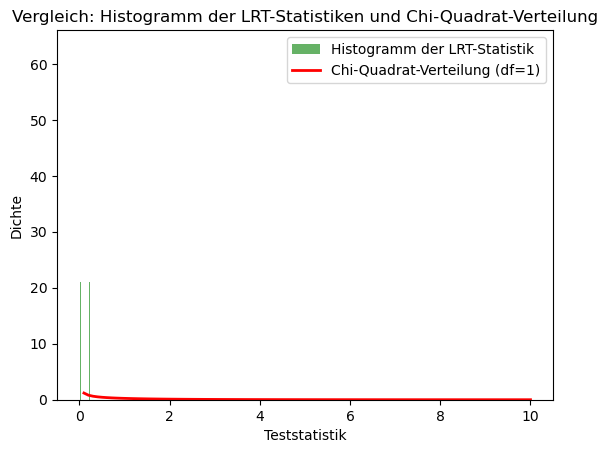

In [ ]:
hist = []
for val in lrt_results:
    if  val > 0:
        hist.append(val)

# Histogramm der Teststatistiken erstellen
plt.hist(hist, bins=70, density=True, alpha=0.6, color='g', label='Histogramm der LRT-Statistik')

# Chi-Quadrat-Verteilung mit zwei Freiheitsgraden plotten (für Vergleich)
x = np.linspace(0, 10, 100)
plt.plot(x, chi2.pdf(x, df=1), 'r-', lw=2, label='Chi-Quadrat-Verteilung (df=1)')

# Beschriftungen hinzufügen
plt.title('Vergleich: Histogramm der LRT-Statistiken und Chi-Quadrat-Verteilung')
plt.xlabel('Teststatistik')
plt.ylabel('Dichte')
plt.legend()

# Histogramm anzeigen
plt.show()

In [ ]:
data = lrt_results

# Negative Werte aus den Daten entfernen
cleaned_data = data[data >= 0]

# Anzahl der Bins für das Histogramm
num_bins = 10

# Histogramm der Daten erstellen
hist, bin_edges = np.histogram(cleaned_data, bins=num_bins, density=True)

# Mittelpunkte der Bins berechnen
bin_midpoints = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Erwartete Häufigkeiten anhand der Chi-Quadrat-Verteilung berechnen
expected_freq = stats.chi2.pdf(bin_midpoints, df=1)

# Erwartete Häufigkeiten an die Summe der Histogrammhöhen anpassen
expected_freq = expected_freq * np.sum(hist) / np.sum(expected_freq)

# Chi-Quadrat-Goodness-of-Fit-Test durchführen
chi2_stat, p_value = stats.chisquare(hist, expected_freq)

# Ergebnisse anzeigen
print(f'Chi-Quadrat-Statistik: {chi2_stat}')
print(f'p-Wert: {p_value}')

# Histogramm und erwartete Verteilung plotten
plt.hist(cleaned_data, bins=num_bins, density=True, alpha=0.6, color='g', label='Histogramm der LRT-Statistik')
plt.plot(bin_midpoints, expected_freq, 'r--', label='Erwartete Chi-Quadrat-Verteilung')
plt.xlabel('Werte')
plt.ylabel('Dichte')
plt.legend()
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

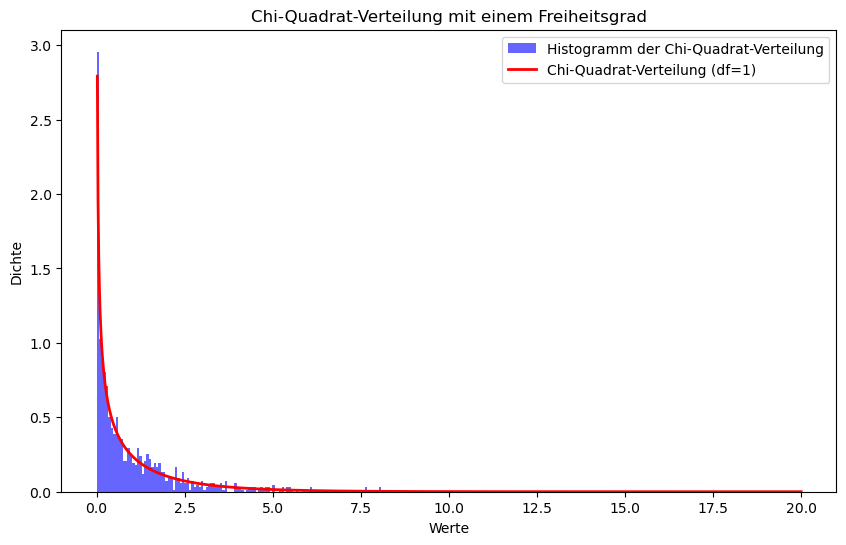

In [ ]:
# Parameters
df = 1  # degrees of freedom
size = 1000  # sample size

# Generate chi-squared distributed data
data = np.random.chisquare(df, size)

# Create histogram with 1000 bins
plt.figure(figsize=(10, 6))
plt.hist(data, bins=120, density=True, alpha=0.6, color='b', label='Histogramm der Chi-Quadrat-Verteilung')

# Chi-Quadrat-Verteilung mit zwei Freiheitsgraden plotten (für Vergleich)
x = np.linspace(0, 20, 1000)
plt.plot(x, chi2.pdf(x, df=1), 'r-', lw=2, label='Chi-Quadrat-Verteilung (df=1)')


# Add labels and title
plt.title(f'Chi-Quadrat-Verteilung mit einem Freiheitsgrad')
plt.xlabel('Werte')
plt.ylabel('Dichte')
plt.legend()

# Show plot
plt.show()